Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [4]:
import sys
sys.path.append("../..")
from src import convex_return_mapping as crm # there is a conflict in the order of imported modules

import meshio
import ufl
from dolfinx import fem, io, common
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np

from src import fenicsx_support as fs
from src import plasticity_framework as pf

In [5]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("../mesh/thick_cylinder_coarse.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)


<meshio mesh object>
  Number of points: 50
  Number of cells:
    line: 2
    line: 14
    line: 2
    line: 11
    triangle: 69
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [6]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [7]:
# elastic parameters
sig0_dim = 70e3 #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim #[-]
nu = 0.3 #[-]
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))

sig0 = 250 / sig0_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

sigt = 250 / sig0_dim # tensile strength
sigc = 250 / sig0_dim # compression strength

In [8]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)

In [9]:
sig = fem.Function(W)
sig_old = fem.Function(W)
p = fem.Function(W0, name="Cumulative_plastic_strain")
p_old = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
Du = fem.Function(V, name="Current_increment")
v_ = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

deps = fem.Function(W, name="deps")

In [10]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [11]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

In [12]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

SQRT2 = np.sqrt(2.)

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def eps_vec(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_vector([e[0, 0], e[1, 1], 0, SQRT2 * e[0, 1]])

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3] / SQRT2, 0],
                          [X[3] / SQRT2, X[1], 0],
                          [0, 0, X[2]]])       
                          
def sigma(eps_el):
    return lmbda*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu*eps_el

In [13]:
vonMises = crm.vonMises(sig0, H)
Rankine = crm.Rankine(sigt, sigc, H)
alpha = 0.
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)

n_quadrature_points = len(p.x.array)

N = patch_size = 3 # or batch, or group ?
N_patches = int(n_quadrature_points / patch_size)
residue_size = n_quadrature_points % patch_size

return_mapping = crm.ReturnMapping(material, patch_size, 'SCS')

p_values = p.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
p_old_values = p_old.x.array[:n_quadrature_points - residue_size].reshape((-1, patch_size))
deps_values = deps.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_values = sig.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
sig_old_values = sig_old.x.array[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))

if residue_size != 0:
    return_mapping_residue = crm.ReturnMapping(material, residue_size, 'SCS')
    
    p_values_residue = p.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    p_old_values_residue = p_old.x.array[n_quadrature_points - residue_size:].reshape((1, residue_size))
    deps_values_residue = deps.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_values_residue = sig.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))
    sig_old_values_residue = sig_old.x.array[4*(n_quadrature_points - residue_size):].reshape((1, residue_size, 4))

In [14]:
tol = 1.0e-13
scs_params = {'eps': tol, 'eps_abs': tol, 'eps_rel': tol}
ecos_params = {'max_iters': 2500, 'abstol': tol, 'reltol': tol, 'feastol': tol}
conic_solver_params = scs_params

In [15]:
# SNES doesn't work with any yield criteria, only if we can define expression of 'deps_p'

# petsc_options_SNES = {
#     "snes_type": "vinewtonrsls",
#     "snes_linesearch_type": "basic",
#     "ksp_type": "preonly",
#     "pc_type": "lu",
#     "pc_factor_mat_solver_type": "mumps",
#     "snes_atol": 1.0e-08,
#     "snes_rtol": 1.0e-08,
#     "snes_stol": 0.0,
#     "snes_max_it": 500,
#     "snes_monitor": "",
# }

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #lbfgs broyden, badbroyden
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", #<powell,periodic,none> 
    "pc_type": "cholesky", # cholesky >> hypre > gamg,sor ; asm, lu, gas - don't work
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

def inside_Newton():
    fs.interpolate_quadrature(eps_vec(Du), deps) # eps_xy * sqrt(2.)!

    for q in range(N_patches):
        return_mapping.deps.value[:] = deps_values[q,:].T
        return_mapping.sig_old.value[:] = sig_old_values[q,:].T
        return_mapping.p_old.value = p_old_values[q,:]
        
        return_mapping.solve(**conic_solver_params)

        sig_values[q,:] = return_mapping.sig.value[:].T
        p_values[q,:] = return_mapping.p.value

    if residue_size != 0: #how to improve ?
        return_mapping_residue.deps.value[:] = deps_values_residue[0,:].T
        return_mapping_residue.sig_old.value[:] = sig_old_values_residue[0,:].T
        return_mapping_residue.p_old.value = p_old_values_residue[0,:]
        
        return_mapping_residue.solve(**conic_solver_params)

        sig_values_residue[0,:] = return_mapping_residue.sig.value[:].T
        p_values_residue[0,:] = return_mapping_residue.p.value

residual = ufl.inner(as_3D_tensor(sig), eps(u_))*dx - F_ext(u_)
J = ufl.derivative(ufl.inner(sigma(eps(Du)), eps(u_))*dx, Du, v_)

snes_problem = pf.SNESProblem(residual, Du, J, bcs, petsc_options=petsc_options_SNESQN, inside_Newton=inside_Newton)

In [16]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

In [17]:
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
p_old.vector.set(0.0)
u.vector.set(0.0)

with common.Timer() as timer: 
    for (i, t) in enumerate(load_steps):
        loading.value = t * q_lim

        Du.x.array[:] = 0
        
        if MPI.COMM_WORLD.rank == 0:
            print(f"\n Increment: {str(i+1)}, load = {t * q_lim}")

        snes_problem.solve()

        u.vector.axpy(1, Du.vector) # u = u + 1*Du
        u.x.scatter_forward()

        p_old.x.array[:] = p.x.array        
        sig_old.x.array[:] = sig.x.array

        if len(points_on_proc) > 0:
            results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)
    
    print(f'\nrank#{MPI.COMM_WORLD.rank}: Time = {timer.elapsed()[0]:.3f} (s)')


 Increment: 1, load = 0.0002537449238735671
  0 SNES Function norm 8.904703628988e-05 
  1 SNES Function norm 3.064185113703e-14 

 Increment: 2, load = 0.00035884951272532715
  0 SNES Function norm 3.688449013515e-05 
  1 SNES Function norm 3.086103208250e-14 

 Increment: 3, load = 0.0004394991003117152
  0 SNES Function norm 2.830246470246e-05 
  1 SNES Function norm 1.781630237624e-14 

 Increment: 4, load = 0.0005074898477471342
  0 SNES Function norm 2.386008146350e-05 
  1 SNES Function norm 1.972311114837e-14 

 Increment: 5, load = 0.0005673908987268053
  0 SNES Function norm 2.102115375804e-05 
  1 SNES Function norm 5.997644430117e-15 

 Increment: 6, load = 0.000621545588311601
  0 SNES Function norm 1.900457567825e-05 
  1 SNES Function norm 8.639097121796e-15 

 Increment: 7, load = 0.0006713459650144749
  0 SNES Function norm 1.747651099307e-05 
  1 SNES Function norm 7.260276514540e-18 

 Increment: 8, load = 0.0007176990254506543
  0 SNES Function norm 1.626673981019e

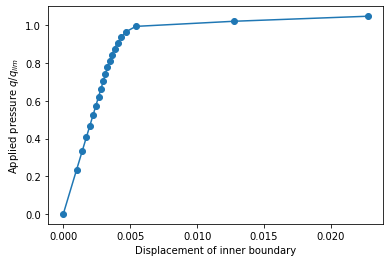

In [18]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()